<a href="https://colab.research.google.com/github/raniabaadj/Our-approach/blob/main/our_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:47<00:00, 52.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
# prompt: copy  /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2 to  content using  shell

!cp -r /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2 /content

In [ ]:
# Vérifie le contenu du dossier
!ls /content/2

chest_xray


In [ ]:
# Chemin vers ton dataset
train_dir = '/content/2/chest_xray/train'
val_dir = '/content/2/chest_xray/val'
test_dir = '/content/2/chest_xray/test'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Préparation des générateurs d'images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Créer les datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 16 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


**Densenet201**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201


base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Input
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Model final
model = tf.keras.Model(inputs, outputs)

# Compiler
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,814,017 (71.77 MB)

 Trainable params: 492,033 (1.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

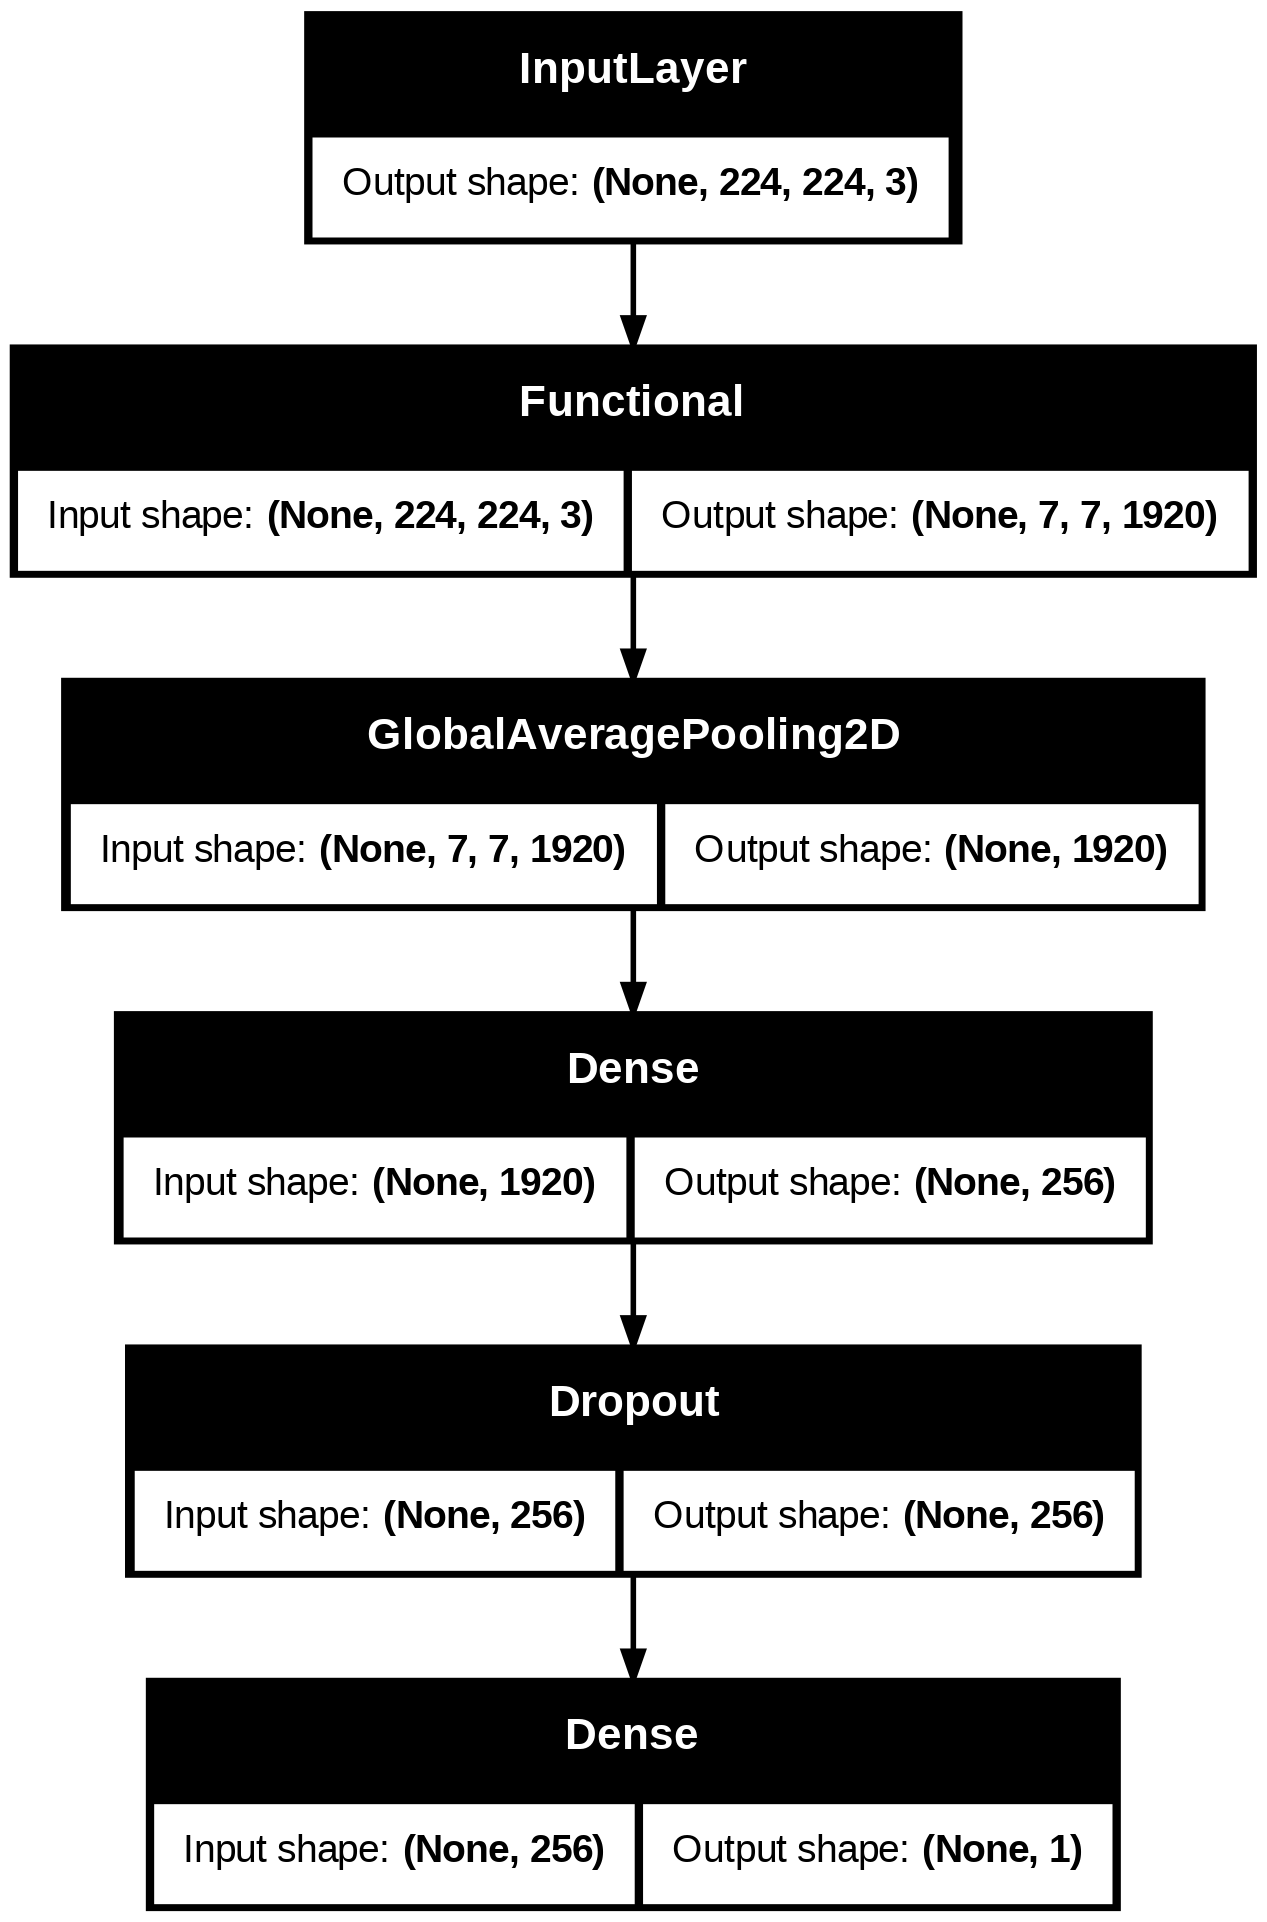

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import normalize
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
# Entraînement
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 183s 821ms/step - accuracy: 0.8055 - loss: 0.4220 - val_accuracy: 0.6875 - val_loss: 0.4602
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 630ms/step - accuracy: 0.9181 - loss: 0.2019 - val_accuracy: 0.8125 - val_loss: 0.3914


In [ ]:
# Évaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step - accuracy: 0.7111 - loss: 0.5417
Test accuracy: 0.84


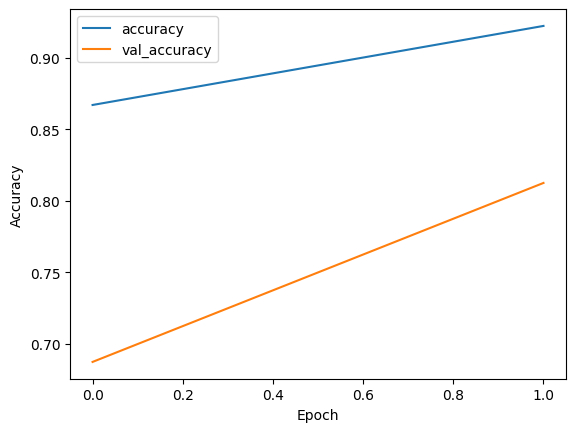

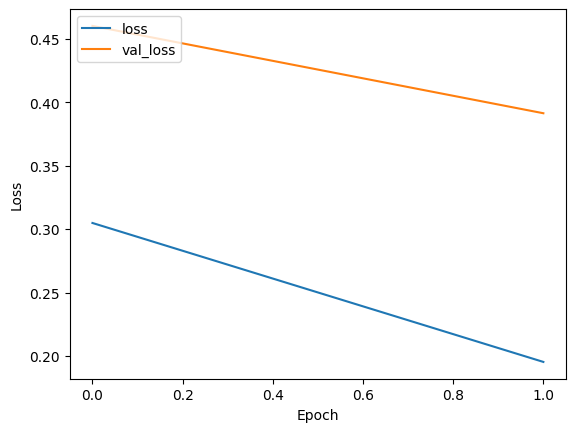

In [ ]:
import matplotlib.pyplot as plt

# Courbes d'entraînement
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Courbes de perte
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
model.save('modeldensenet.h5')

**VGG19**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
# Charger VGG19 sans la top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Construire le modèle avec API fonctionnelle
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

modelvgg19 = models.Model(inputs, outputs)

# Compiler
modelvgg19.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

modelvgg19.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,155,969 (76.89 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
history = modelvgg19.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 747ms/step - accuracy: 0.6751 - loss: 0.6337 - val_accuracy: 0.5000 - val_loss: 0.7205
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 764ms/step - accuracy: 0.7752 - loss: 0.4685 - val_accuracy: 0.5625 - val_loss: 0.6353


In [ ]:
test_loss, test_acc = modelvgg19.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.3968 - loss: 0.8152
Test accuracy: 0.67


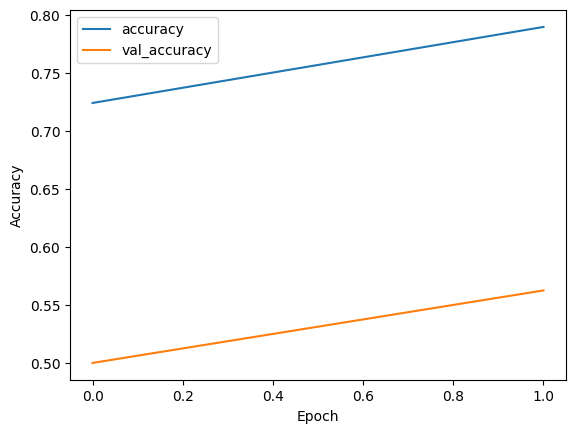

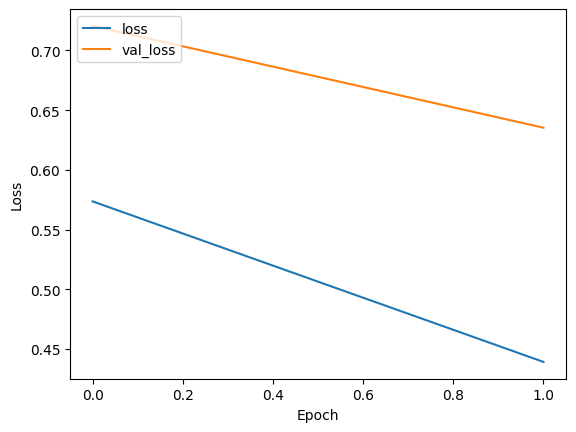

In [ ]:
import matplotlib.pyplot as plt

# Courbes d'entraînement
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Courbes de perte
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
model.save('modelvgg19.h5')


**ResNet50**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
# Charger ResNet50 sans la top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # On gèle ResNet50

# Construire le modèle avec API fonctionnelle
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

modelresnet = models.Model(inputs, outputs)

# Compiler
modelresnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

modelresnet.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = modelresnet.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)

Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 654ms/step - accuracy: 0.6584 - loss: 0.6784 - val_accuracy: 0.5000 - val_loss: 0.8039
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 634ms/step - accuracy: 0.7395 - loss: 0.5726 - val_accuracy: 0.5000 - val_loss: 0.7891


In [ ]:
test_loss, test_acc = modelresnet.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.2984 - loss: 0.9575
Test accuracy: 0.62


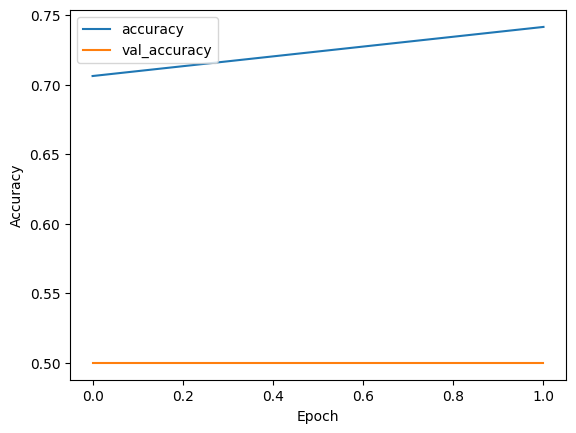

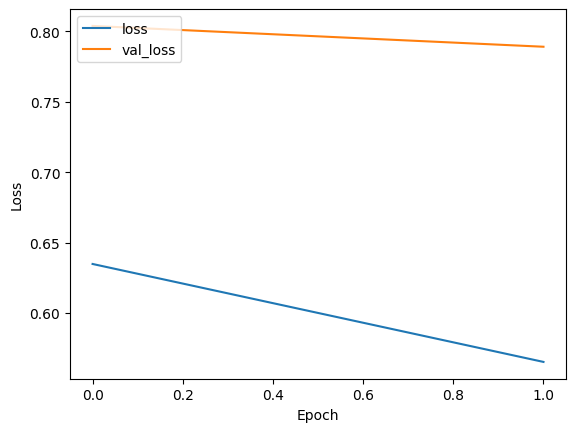

In [ ]:
import matplotlib.pyplot as plt

# Courbes d'entraînement
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Courbes de perte
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
model.save('modelresnet.h5')

Stacking Technic

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Chemins vers les modèles pré-entraînés
vgg19_model = load_model('modelvgg19.h5')
resnet50_model = load_model('modelresnet.h5')
densenet201_model = load_model('modeldensenet.h5')

# On suppose que chaque modèle a une couche finale de classification qu'on ne veut pas utiliser ici
# On les remplace par la sortie avant classification (par exemple la dernière couche dense ou pooling)
vgg19_features = Model(inputs=modelvgg19.input, outputs=modelvgg19.layers[-2].output)
resnet50_features = Model(inputs=modelresnet.input, outputs=modelresnet.layers[-2].output)
densenet201_features = Model(inputs=model.input, outputs=model.layers[-2].output)

# Geler les modèles de base (optionnel)
vgg19_features.trainable = False
resnet50_features.trainable = False
densenet201_features.trainable = False

# Input commun
input_layer = Input(shape=(224, 224, 3))  # à adapter selon ton preprocessing

# Obtenir les features
vgg_output = vgg19_features(input_layer)
resnet_output = resnet50_features(input_layer)
densenet_output = densenet201_features(input_layer)

# Combiner les features
combined = Concatenate()([vgg_output, resnet_output, densenet_output])

# Meta-classifier
x = Dropout(0.5)(combined)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # ou softmax pour multi-classes

# Modèle final
stacked_model = Model(inputs=input_layer, outputs=output)

# Compilation
stacked_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement
history1=stacked_model.fit(train_generator, validation_data=val_generator, epochs=2)


Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 904ms/step - accuracy: 0.7525 - loss: 0.4937 - val_accuracy: 0.6875 - val_loss: 0.5418
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 741ms/step - accuracy: 0.9000 - loss: 0.2435 - val_accuracy: 0.7500 - val_loss: 0.4821


In [ ]:
test_loss, test_acc = stacked_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.6598 - loss: 0.7110
Test accuracy: 0.82


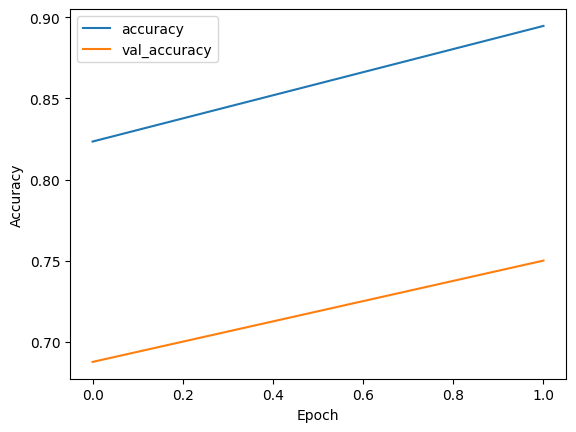

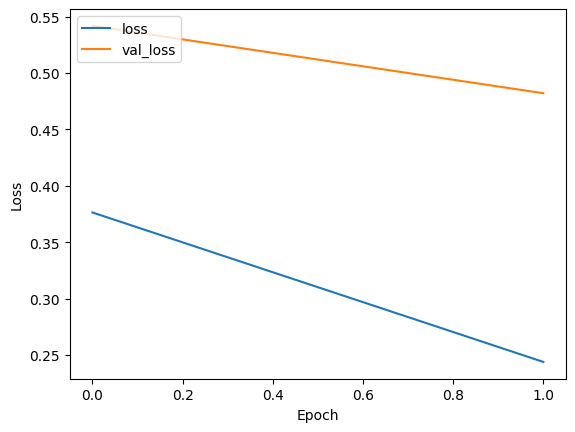

In [ ]:
import matplotlib.pyplot as plt

# Courbes d'entraînement
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Courbes de perte
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 389ms/step


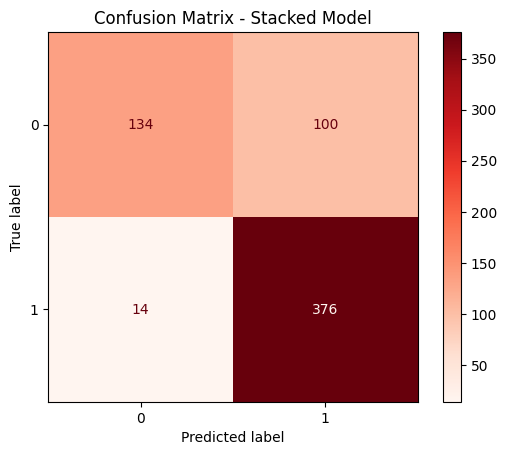

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Générer les prédictions sur le test set
test_predictions = stacked_model.predict(test_generator)

# Si la sortie est une probabilité (sigmoid), on binarise :
test_predictions = (test_predictions > 0.5).astype(int).flatten()

# Obtenir les vraies étiquettes
# Cela fonctionne si test_generator a été créé via ImageDataGenerator.flow_from_directory(...)
test_true_labels = test_generator.classes

# Matrice de confusion
cm = confusion_matrix(test_true_labels, test_predictions)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix - Stacked Model")
plt.show()


Genetic Algorithme **GA**

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import random

# Charger les modèles entraînés
vgg_model = load_model('modelvgg19.h5')
resnet_model = load_model('modelresnet.h5')
densenet_model = load_model('modeldensenet.h5')

# Faire les prédictions sur le dataset de validation
vgg_preds = modelvgg19.predict(val_generator)
resnet_preds = modelresnet.predict(val_generator)
densenet_preds = model.predict(val_generator)

# Assure-toi que les prédictions sont aplaties
vgg_preds = vgg_preds.reshape(-1)
resnet_preds = resnet_preds.reshape(-1)
densenet_preds = densenet_preds.reshape(-1)


y_val = val_generator.classes

# Fonction fitness : précision des prédictions pondérées
def fitness(weights):
    weights = np.array(weights)
    weights = weights / np.sum(weights)  # Normaliser
    combined = (
        weights[0] * vgg_preds +
        weights[1] * resnet_preds +
        weights[2] * densenet_preds
    )
    preds_binary = (combined > 0.5).astype(int)
    return accuracy_score(y_val, preds_binary)

# Algorithme génétique
def genetic_algorithm(pop_size=10, generations=20, mutation_rate=0.1):
    # Initialiser une population de poids aléatoires
    population = [np.random.dirichlet(np.ones(3)).tolist() for _ in range(pop_size)]

    for gen in range(generations):
        scores = [fitness(ind) for ind in population]
        print(f"Génération {gen+1} | Meilleure précision : {max(scores):.4f}")

        # Sélection des meilleurs
        sorted_pop = [x for _, x in sorted(zip(scores, population), reverse=True)]
        parents = sorted_pop[:2]  # les 2 meilleurs

        # Nouvelle génération
        new_population = parents.copy()

        while len(new_population) < pop_size:
            # Crossover (mélange)
            p1, p2 = random.sample(parents, 2)
            alpha = np.random.rand()
            child = (alpha * np.array(p1) + (1 - alpha) * np.array(p2)).tolist()

            # Mutation
            if np.random.rand() < mutation_rate:
                idx = np.random.randint(0, 3)
                child[idx] = np.clip(child[idx] + np.random.normal(0, 0.1), 0, 1)
                child = (np.array(child) / np.sum(child)).tolist()

            new_population.append(child)

        population = new_population

    # Retourne le meilleur ensemble de poids
    final_scores = [fitness(ind) for ind in population]
    best_weights = population[np.argmax(final_scores)]
    print(f"\nPoids optimaux trouvés : {best_weights}")
    return best_weights

# Lancer l'algorithme
best_weights = genetic_algorithm()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Génération 1 | Meilleure précision : 0.5000
Génération 2 | Meilleure précision : 0.5000
Génération 3 | Meilleure précision : 0.5000
Génération 4 | Meilleure précision : 0.5000
Génération 5 | Meilleure précision : 0.5000
Génération 6 | Meilleure précision : 0.5000
Génération 7 | Meilleure précision : 0.5000
Génération 8 | Meilleure précision : 0.5000
Génération 9 | Meilleure précision : 0.5000
Génération 10 | Meilleure précision : 0.5000
Génération 11 | Meilleure précision : 0.5000
Génération 12 | Meilleure précision : 0.5000
Génération 13 | Meilleure précision : 0.5000
Génération 14 | Meilleure précision : 0.5000
Génération 15 | Meilleure précision : 0.5000
Génération 16 | Meilleure précision : 0.5000
Génération 17 | Meilleure précision : 0.5000
Génération 18 | Meilleure précision : 0.5000
Génération 19 | Meilleure précision : 0.5000
Génération 20 | Meilleure précision :

In [ ]:
# Appliquer les meilleurs poids aux prédictions
final_preds = (
    best_weights[0] * vgg_preds +
    best_weights[1] * resnet_preds +
    best_weights[2] * densenet_preds
)
final_preds = (final_preds > 0.5).astype(int)

# Précision finale
final_acc = accuracy_score(y_val, final_preds)
print(f"\nPrécision finale de l'ensemble pondéré : {final_acc:.4f}")



Précision finale de l'ensemble pondéré : 0.5000
